This is code for looking at the problem "Can patient healthcare records predict the likelihood of mortality in an emergency room visit?"

We start by loading the data tables for patients (https://mimic.physionet.org/mimictables/patients/) and admissions (https://mimic.physionet.org/mimictables/admissions/), followed by merging them together, adding an Age field and filtering down to ER admits.


In [1]:
#Load libraries that will be used throughout
import numpy as np
import pandas as pd
from IPython.display import display 
%matplotlib inline

# read patients data
patients_data = pd.read_csv('raw_data/PATIENTS_DATA_TABLE.csv')
print "Patients data has {} records with {} columns.".format(*patients_data.shape)

# read admissions data
admissions_data = pd.read_csv('raw_data/ADMISSIONS_DATA_TABLE.csv', dtype={'HADM_ID':str})
print "Admissions data has {} records with {} columns.".format(*admissions_data.shape)

# join the data together on SUBJECT_ID
merged_demographic_data = pd.merge(patients_data, admissions_data, on='SUBJECT_ID')
print "Merged demographic data has {} records with {} columns.".format(*merged_demographic_data.shape)

# add an Age field to the dataframe
import datetime
def convertDatetimeField(datetime_str):
    return datetime.datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')

def calcAge(birth, date):
    age = date.year - birth.year
    
    if date.month < birth.month:
        age -= 1
    elif date.month == birth.month and date.day < birth.day:
        age -= 1       
        
    if (age >=300):
        age = 91
        
    return age

def addAgesToData(data):
    admits = map(convertDatetimeField, data['ADMITTIME'])
    births = map(convertDatetimeField, data['DOB'])
    ages = [calcAge(birth, admit) for (admit, birth) in zip(admits, births)]
    data['AGE'] = ages

addAgesToData(merged_demographic_data)

# filter down to ER admits
er_demographic_data = \
    merged_demographic_data[merged_demographic_data['ADMISSION_LOCATION'] == 'EMERGENCY ROOM ADMIT'].reset_index(drop=True)
print "ER demographic data has {} records with {} columns.".format(*er_demographic_data.shape)

print "ER demographic data covers {} patients.".format(len(er_demographic_data['SUBJECT_ID'].unique()))
er_demographic_data.loc[0]

Patients data has 46520 records with 8 columns.
Admissions data has 58976 records with 20 columns.
Merged demographic data has 58976 records with 27 columns.
ER demographic data has 22754 records with 28 columns.
ER demographic data covers 17971 patients.


ROW_ID_x                                   617
SUBJECT_ID                                 651
GENDER                                       M
DOB                        2138-07-21 00:00:00
DOD                                        NaN
DOD_HOSP                                   NaN
DOD_SSN                                    NaN
EXPIRE_FLAG                                  0
ROW_ID_y                                   806
HADM_ID                                 110245
ADMITTIME                  2186-07-25 03:13:00
DISCHTIME                  2186-07-27 19:06:00
DEATHTIME                                  NaN
ADMISSION_TYPE                       EMERGENCY
ADMISSION_LOCATION        EMERGENCY ROOM ADMIT
DISCHARGE_LOCATION                        HOME
INSURANCE                             Medicare
LANGUAGE                                   NaN
RELIGION                     PROTESTANT QUAKER
MARITAL_STATUS                          SINGLE
ETHNICITY               BLACK/AFRICAN AMERICAN
EDREGTIME    

Next, we look at some summary statistics for the data as a whole and the ER data.

In [2]:
def printSummaryStats(data):
    print "In-hospital mortality rate = {}".format(\
                float(data['HOSPITAL_EXPIRE_FLAG'].sum()) / data['SUBJECT_ID'].count())    
    print "Mean age = {}".format(data['AGE'].mean())
    print "Percentage of men = {}".format(\
                float(data[data['GENDER'] == 'M']['SUBJECT_ID'].count()) / data['SUBJECT_ID'].count()) 
    
print "MIMIC-III:"
printSummaryStats(merged_demographic_data)
print 
print "ER patients:"
printSummaryStats(er_demographic_data)

MIMIC-III:
In-hospital mortality rate = 0.0992607162235
Mean age = 54.7274654097
Percentage of men = 0.558701844818

ER patients:
In-hospital mortality rate = 0.135844247165
Mean age = 62.9145205239
Percentage of men = 0.546189680935


This was some code used to look at the raw mortality rate data; the bar graphs are another way of looking at this, but the function is also used elsewhere in the code.

In [3]:
def calcMortalityRateGroupedByFeature(data, feature):
    count = data.groupby(feature).count()['HADM_ID']
    expires = data.groupby(feature).sum()['HOSPITAL_EXPIRE_FLAG']
    
    print
    print "Mortality rates by {}: {} distinct items".format(feature, len(count))
    for key in count.keys():
        print key, float(expires[key]) / count[key], count[key]
    
#calcMortalityRateGroupedByFeature(er_demographic_data, 'AGE')
#calcMortalityRateGroupedByFeature(er_demographic_data, 'GENDER')
#calcMortalityRateGroupedByFeature(er_demographic_data, 'INSURANCE')
#calcMortalityRateGroupedByFeature(er_demographic_data, 'MARITAL_STATUS')
#calcMortalityRateGroupedByFeature(er_demographic_data, 'ETHNICITY')
#calcMortalityRateGroupedByFeature(er_demographic_data, 'RELIGION')
    

This is a helper method for sifting out the values whose frequency in the data set is above a given threshold.  The threshold can either be a percentage between 0.0 and 1.0, or an absolute number of values > 1.

In [4]:
def calculateValuesAboveThresholdForKey(data, key, threshold):
    value_counts = data[key].value_counts()
    total = np.sum(value_counts)
    if (threshold <= 1.0):  #treat it as a percentage
        values = value_counts[value_counts > threshold * total].keys()
    else: #treat it as a minimum number of values
        values = value_counts[value_counts > threshold].keys()
    return values

This a method for visualizing frequencies across a given key dimension -- I took the survival_stats function from P0 as a
starting point and modified it

In [5]:
import matplotlib.pyplot as plt

# keyValues allows a specific set of keys to be considered -- the default behavior is to use all keys.  This only works
# with categorical data
#
# thresholdPct allows specification of threshold for how frequently a key must appear to be graphed as a percentage of all rows 
# -- this again only works with categorical data
#
# figSize allows an alternate value to be passed in if the default figsize is crunching the y-axis too much.  This was an issue
# for ETHNICITY
#
# if both key values and thresholdPct are specified, keyValues overrides thresholdPct
def visualizeFrequencyData(data, key, keyValues = [], thresholdPct = 0.0, figsize = (8, 6)):
    
    # Check that the key exists
    if key not in data.columns.values :
        print "'{}' is not a feature of the data.".format(dimension)
        return False    
   
    all_data = data.copy()
    
    # Create a data frame for the 
    all_data = all_data[[key]]
    
    # Create plotting figure
    plt.figure(figsize=figsize)

    # 'Numerical' features
    if(key == 'AGE'):
        
        # Remove NaN values from Age data
        chart_data = all_data[~np.isnan(all_data[key])]
        
        # Divide the range of data into bins and count survival rates
        min_value = chart_data[key].min()
        max_value = chart_data[key].max()
        value_range = max_value - min_value

        bins = np.arange(10, chart_data['AGE'].max() + 10, 10)
        
        # Overlay each bin's survival rates
        binned_total, bins = np.histogram(chart_data, bins)
       
        # Set the width of each bar
        bar_width = 0.8
       
        tick_labels = []
        for i in np.arange(len(binned_total)):
            plt.barh(i - bar_width/2.0, binned_total[i], height = bar_width, color = 'r')
            tick_labels.append("{} - {}".format(bins[i], bins[i+1]))
        
        # Add legend to plot
        plt.yticks(np.arange(len(tick_labels)), tick_labels)        
    
    # 'Categorical' features
    else:
        if len(keyValues) > 0:
            values = keyValues
        else:
            # This was put in to use thresholdPct, but it has the nice side effect of also sorting the graph by frequency, 
            # so I'm using it even when thresholdPct = 0.0
            values = calculateValuesAboveThresholdForKey(all_data, key, thresholdPct)

        # Create DataFrame containing categories and count of each
        frame = pd.DataFrame(index = np.arange(len(values)), columns=(key,'Total'))
        for i, value in enumerate(reversed(values)):
            frame.loc[i] = [value, \
                   len(all_data[all_data[key] == value])]

        # Set the width of each bar
        bar_width = .8

        # Display each category's survival rates
        for i in np.arange(len(frame)):
            plt.barh(i - bar_width/2.0, frame.loc[i]['Total'], height = bar_width, color = 'r')

        plt.yticks(np.arange(len(frame)), reversed(values))

    # Common attributes for plot formatting
    plt.ylabel(key)
    plt.xlabel("Number of Visits")
    title = "Visit Frequency Statistics With \'{}\' Feature".format(key)
    if sum(pd.isnull(all_data[key])) > 0:
        nan_outcomes = all_data[pd.isnull(all_data[key])]
        title += "\nVisits with missing values: {}".format(len(nan_outcomes))  
    plt.title(title)
    plt.show()    

Use the method above to visualize the frequency stats for demographic features.

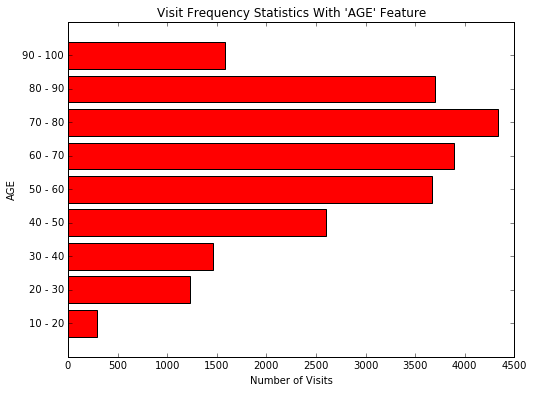

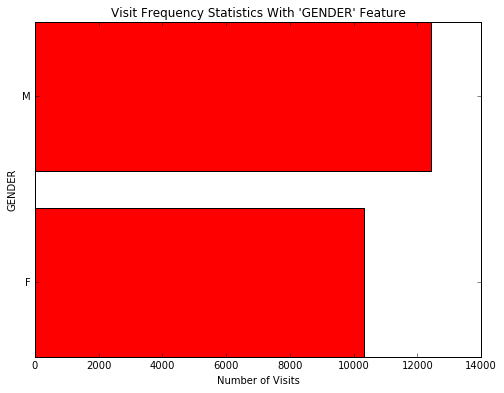

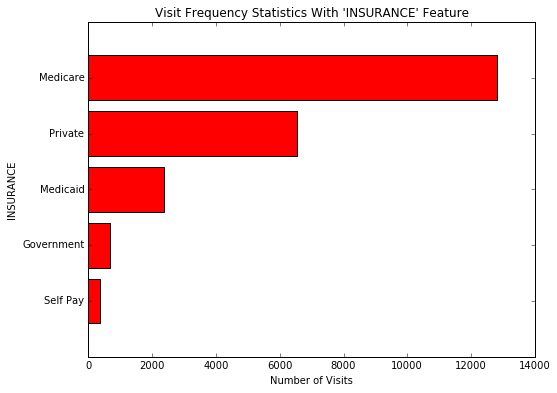

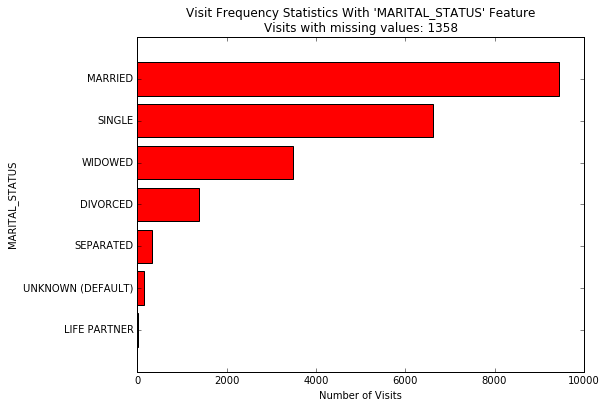

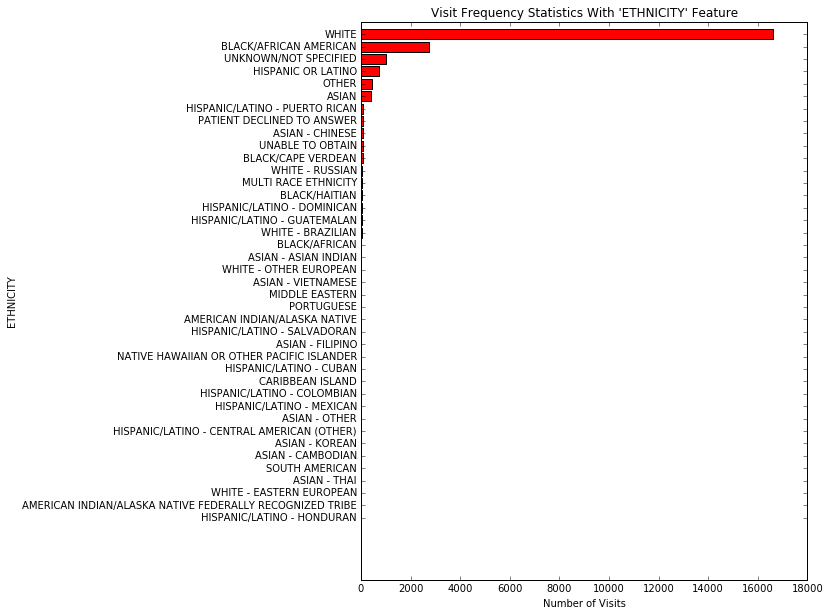

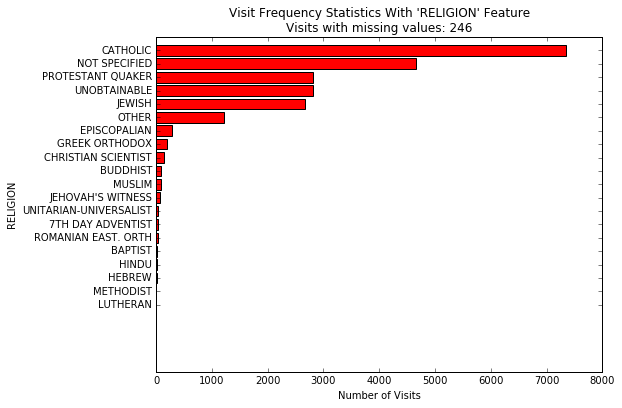

In [6]:
visualizeFrequencyData(er_demographic_data, 'AGE')  
visualizeFrequencyData(er_demographic_data, 'GENDER')
visualizeFrequencyData(er_demographic_data, 'INSURANCE')
visualizeFrequencyData(er_demographic_data, 'MARITAL_STATUS')
visualizeFrequencyData(er_demographic_data, 'ETHNICITY', figsize=(8, 10))
visualizeFrequencyData(er_demographic_data, 'RELIGION')

Based on the results above, do some data cleaning; see the report for a more in depth discussion.

In [7]:
#Merge infrequent values and 'None' values into 'OTHER'
for feature in ['MARITAL_STATUS', 'ETHNICITY', 'RELIGION']:
    topValues = calculateValuesAboveThresholdForKey(er_demographic_data, feature, .01)
    er_demographic_data.loc[~er_demographic_data[feature].isin(topValues), feature] = 'OTHER'
    
# Set fields corresponding to concepts of 'unspecified' or 'other' to None for consistency
er_demographic_data.loc[er_demographic_data['RELIGION'].isin(['UNOBTAINABLE', 'NOT SPECIFIED']), 'RELIGION'] = 'OTHER'
er_demographic_data.loc[er_demographic_data['ETHNICITY'].isin(['UNKNOWN/NOT SPECIFIED']), 'ETHNICITY'] = 'OTHER'

This is a similar method to the above for looking at mortality rates.

In [8]:
import matplotlib.pyplot as plt
# keyValues allows a specific set of keys to be considered -- the default behavior is to use all keys.  This only works
# with categorical data
#
# thresholdPct allows specification of threshold for how frequently a key must appear to be graphed as a percentage of all rows 
# -- this again only works with categorical data
#
# figSize allows an alternate value to be passed in if the default figsize is crunching the y-axis too much.  This was an issue
# for ETHNICITY before cleaning
#
# if both key values and thresholdPct are specified, keyValues overrides thresholdPct
#
def visualizeExpiryData(data, key, keyValues = [], thresholdPct = 0.0, figsize=(8, 6)):
    
    # Check that the key exists
    if key not in data.columns.values :
        print "'{}' is not a feature of the data.".format(dimension)
        return False    
   
    all_data = data.copy()
    
    all_data = all_data[[key, 'HOSPITAL_EXPIRE_FLAG']]
    
    # Create plotting figure
    plt.figure(figsize=figsize)

    # 'Numerical' features
    if(key == 'AGE'):
        
        # Remove NaN values from Age data,if any
        chart_data = all_data[~np.isnan(all_data[key])]
        
        # Divide the range of data into bins and count survival rates
        min_value = chart_data[key].min()
        max_value = chart_data[key].max()
        value_range = max_value - min_value

        bins = np.arange(10, chart_data['AGE'].max() + 10, 10)
        
        # Overlay each bin's survival rates
        nonsurv_vals = chart_data[chart_data['HOSPITAL_EXPIRE_FLAG'] == 1][key].reset_index(drop = True)
        
        binned_nonsurv_vals, bins = np.histogram(nonsurv_vals, bins)
        binned_total, bins = np.histogram(chart_data, bins)
       
        # Set the width of each bar
        bar_width = 0.8
       
        tick_labels = []
        for i in np.arange(len(binned_total)):
            plt.barh(i - bar_width/2.0, 1.0*binned_nonsurv_vals[i]/binned_total[i], height = bar_width, color = 'r')
            tick_labels.append("{} - {}".format(bins[i], bins[i+1]))
        
        # Add legend to plot
        plt.yticks(np.arange(len(tick_labels)), tick_labels)        
    
    # 'Categorical' features
    else:
        if len(keyValues) > 0:
            values = keyValues
        else:
            # This was put in to use thresholdPct, but it has the nice side effect of also sorting the graph by frequency, 
            # so I'm using it even when thresholdPct = 0.0
            values = calculateValuesAboveThresholdForKey(all_data, key, thresholdPct)

        # Create DataFrame containing categories and count of each
        frame = pd.DataFrame(index = np.arange(len(values)), columns=(key,'Died','Total'))
        for i, value in enumerate(reversed(values)):
            frame.loc[i] = [value, \
                   len(all_data[(all_data['HOSPITAL_EXPIRE_FLAG'] == 1) & (all_data[key] == value)]), \
                   len(all_data[all_data[key] == value])]

        # Set the width of each bar
        bar_width = 0.8

        # Display each category's survival rates
        for i in np.arange(len(frame)):
            plt.barh(i - bar_width/2.0, 1.0 * frame.loc[i]['Died'] / frame.loc[i]['Total'], height = bar_width, color = 'r')

        plt.yticks(np.arange(len(frame)), reversed(values))

    # Common attributes for plot formatting
    plt.ylabel(key)
    plt.xlabel("Mortality Rate")
    title = "Visit Mortality Rate Across \'{}\' Feature".format(key)
    if sum(pd.isnull(all_data[key])) > 0:
        nan_outcomes = all_data[pd.isnull(all_data[key])]['HOSPITAL_EXPIRE_FLAG']
        title += "\nVisits with missing values: {} (Mortality rate = {:0.3f})".format( \
                      len(nan_outcomes), 1.0*sum(nan_outcomes == 1)/sum(nan_outcomes == 0))  
    plt.title(title)
    plt.show()
    

Use the method above to visualize the mortality rates across various demographic features.

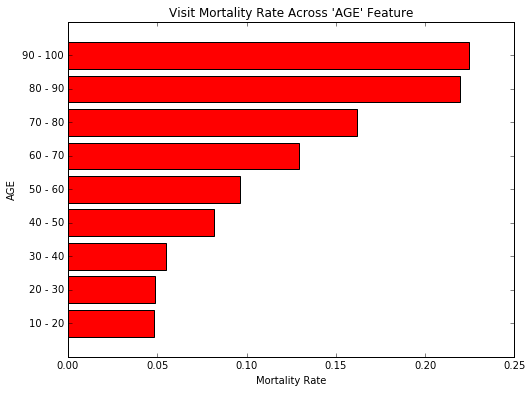

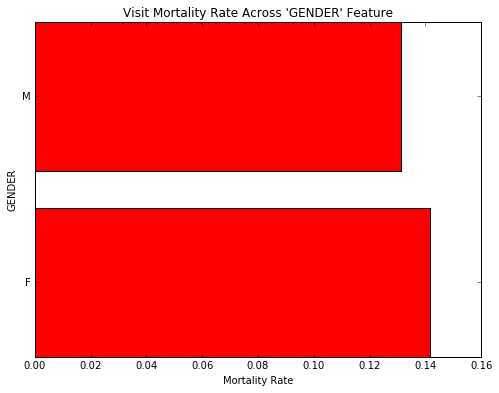

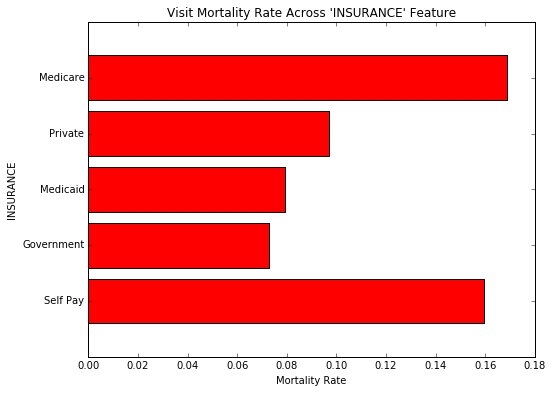

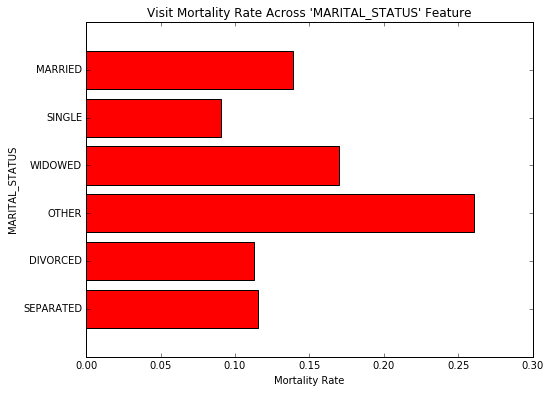

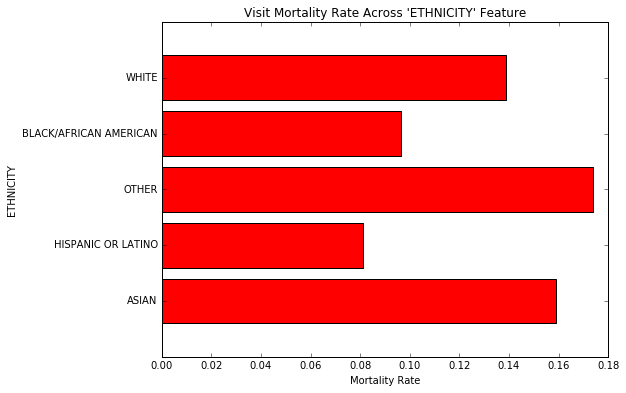

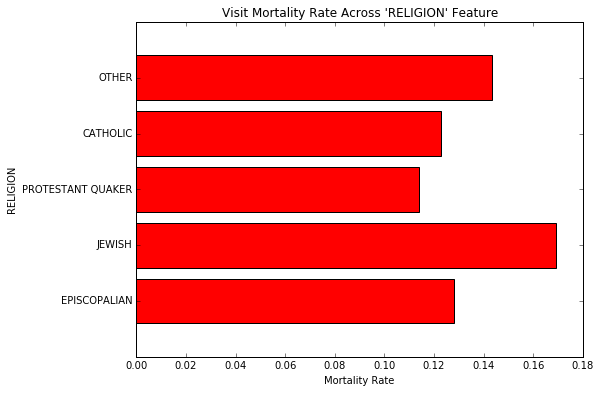

In [9]:
visualizeExpiryData(er_demographic_data, 'AGE')  
visualizeExpiryData(er_demographic_data, 'GENDER')
visualizeExpiryData(er_demographic_data, 'INSURANCE')
visualizeExpiryData(er_demographic_data, 'MARITAL_STATUS')
visualizeExpiryData(er_demographic_data, 'ETHNICITY')
visualizeExpiryData(er_demographic_data, 'RELIGION')

This is a method for looking at how two features correlate -- for the second feature, it plots one line graph
for each value of the feature showing the percentage of the population that has that value for each value of the first
dimension.  The method is then applied to Age vs. the other demographic dimensions.

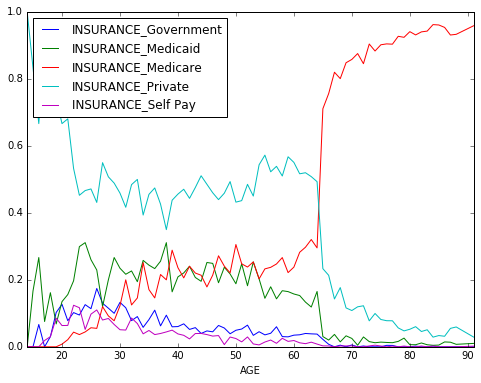

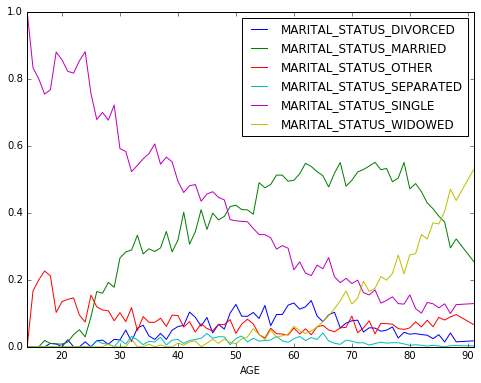

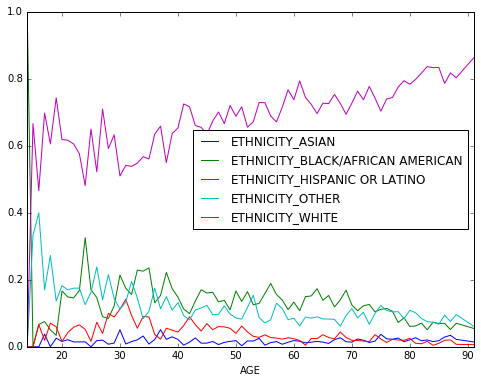

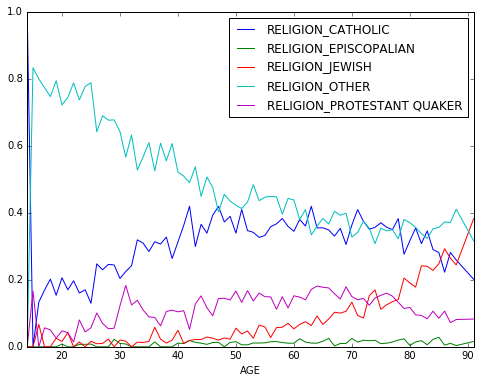

In [10]:
def compareFeatures(data, feature1, feature2, thresholdPct = 0.0):
    comparison_data = data[[feature1, feature2]]
    values = calculateValuesAboveThresholdForKey(comparison_data, feature2, thresholdPct)
    comparison_data = comparison_data[comparison_data[feature2].isin(values)]
    comparison_data = pd.get_dummies(comparison_data, columns = [feature2])
    comparison_data = comparison_data.groupby(feature1).sum()
    comparison_data = comparison_data.div(comparison_data.sum(axis=1), axis=0)
    comparison_data.plot(figsize = (8, 6))

compareFeatures(er_demographic_data, 'AGE', 'INSURANCE')
compareFeatures(er_demographic_data, 'AGE', 'MARITAL_STATUS')
compareFeatures(er_demographic_data, 'AGE', 'ETHNICITY')
compareFeatures(er_demographic_data, 'AGE', 'RELIGION')


This method calculates a pivot table of mortality rates.  One dimension is age sorted into bins, starting from 10-20 and going up through 90-100, and the second dimension is an argument to the function.

In [11]:
#Calculates a pivot of mortality rate by Age and one other input feature
def calcMortalityRatePivot(input_data, key):
    data = input_data.copy()
    
    data = data[['AGE', key, 'HOSPITAL_EXPIRE_FLAG']]
    
    min_value = data['AGE'].min()
    max_value = data['AGE'].max()
    value_range = max_value - min_value

    bins = np.arange(10, data['AGE'].max() + 10, 10)        
    data['AGE_BIN'] = np.digitize(data['AGE'], bins)
    
    key_values = data[key].unique()
    num_key_values = len(key_values)
    
    frame = pd.DataFrame(index = np.arange(len(bins)-1 * len(key_values)), 
                         columns=('AGE_BIN', key,'Died','Total'))    
    for i in (range(1, len(bins))):
        for j, value in enumerate(key_values):
            frame.loc[(i-1)*num_key_values + j] = \
                        [i, value, \
                         len(data[(data['HOSPITAL_EXPIRE_FLAG'] == 1) 
                                  & (data['AGE_BIN'] == i) & (data[key] == value)]), \
                         len(data[(data['AGE_BIN'] == i) & (data[key] == value)])]   
    frame['Mortality Rate'] = frame['Died'].astype("float64") / frame['Total'].astype("float64")

    display(frame.pivot(index='AGE_BIN', columns=key, values='Mortality Rate'))

calcMortalityRatePivot(er_demographic_data, 'INSURANCE')
calcMortalityRatePivot(er_demographic_data, 'RELIGION')
calcMortalityRatePivot(er_demographic_data, 'ETHNICITY')
calcMortalityRatePivot(er_demographic_data, 'MARITAL_STATUS')

INSURANCE,Government,Medicaid,Medicare,Private,Self Pay
AGE_BIN,,,,,
1,0.000000,0.030303,NaN,0.057018,0.000000
2,0.049645,0.041045,0.030769,0.046296,0.094340
3,0.064516,0.038012,0.045614,0.054945,0.148649
4,0.059259,0.086505,0.082333,0.081900,0.075000
5,0.062112,0.077713,0.104561,0.095187,0.290323
6,0.151163,0.116071,0.131226,0.125093,0.321429
7,0.285714,0.152778,0.163013,0.143243,0.428571
8,0.500000,0.166667,0.218249,0.241176,1.000000
9,NaN,0.250000,0.221122,0.326087,0.333333


RELIGION,CATHOLIC,EPISCOPALIAN,JEWISH,OTHER,PROTESTANT QUAKER
AGE_BIN,,,,,
1,0.000000,NaN,0.000000,0.062222,0.000000
2,0.045455,0.000000,0.000000,0.049162,0.073529
3,0.050481,0.250000,0.071429,0.055164,0.055556
4,0.070613,0.035714,0.079365,0.092758,0.076433
5,0.083969,0.093023,0.075269,0.113877,0.079545
6,0.119392,0.132075,0.098101,0.152621,0.112520
7,0.148553,0.120000,0.151104,0.193333,0.133550
8,0.210621,0.170213,0.210648,0.243590,0.184659
9,0.191223,0.240000,0.213576,0.273453,0.167939


ETHNICITY,ASIAN,BLACK/AFRICAN AMERICAN,HISPANIC OR LATINO,OTHER,WHITE
AGE_BIN,,,,,
1,0.200000,0.000000,0.000000,0.116667,0.030769
2,0.058824,0.035533,0.000000,0.079812,0.047684
3,0.076923,0.032258,0.068627,0.093750,0.050588
4,0.111111,0.080556,0.038462,0.129964,0.077489
5,0.122449,0.091912,0.104000,0.111413,0.093895
6,0.171875,0.098566,0.090909,0.224684,0.125526
7,0.182796,0.125541,0.134831,0.199074,0.162112
8,0.253012,0.163866,0.156863,0.264798,0.219155
9,0.043478,0.195402,0.300000,0.360825,0.219369


MARITAL_STATUS,DIVORCED,MARRIED,OTHER,SEPARATED,SINGLE,WIDOWED
AGE_BIN,,,,,,
1,0.000000,0.000000,0.204082,NaN,0.016878,NaN
2,0.083333,0.038095,0.145833,0.000000,0.035343,0.000000
3,0.000000,0.039171,0.151261,0.040000,0.052248,0.200000
4,0.069519,0.069601,0.189349,0.065574,0.080411,0.029412
5,0.084469,0.099295,0.209040,0.101266,0.084622,0.033333
6,0.108808,0.125498,0.308458,0.141176,0.103292,0.137195
7,0.156522,0.156181,0.304511,0.183673,0.145865,0.144706
8,0.205128,0.232770,0.332117,0.230769,0.203501,0.186779
9,0.321429,0.228288,0.380952,0.000000,0.200980,0.206938


Trim the data down to only columns needed for the analysis; HADM_ID is left in place to facilitate merging with diagnosis data later.  Then, replace the demographic fields with binary valued fields, one for each value.

In [18]:
#Scale the age data
from sklearn.preprocessing import MinMaxScaler
minmaxscaler = MinMaxScaler()
er_demographic_data['SCALED_AGE'] = minmaxscaler.fit_transform(er_demographic_data['AGE'])

#Cut the columns down to only include fields that we'll use in the analysis
er_demo_analysis_data = \
    er_demographic_data[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG', 'SCALED_AGE', \
                         'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'RELIGION', 'GENDER']]  
er_demo_analysis_data = \
    pd.get_dummies(er_demo_analysis_data, columns=['INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'RELIGION', 'GENDER'])    
  
print er_demo_analysis_data.loc[0]

HADM_ID                               110245
HOSPITAL_EXPIRE_FLAG                       0
SCALED_AGE                          0.441558
INSURANCE_Government                       0
INSURANCE_Medicaid                         0
INSURANCE_Medicare                         1
INSURANCE_Private                          0
INSURANCE_Self Pay                         0
MARITAL_STATUS_DIVORCED                    0
MARITAL_STATUS_MARRIED                     0
MARITAL_STATUS_OTHER                       0
MARITAL_STATUS_SEPARATED                   0
MARITAL_STATUS_SINGLE                      1
MARITAL_STATUS_WIDOWED                     0
ETHNICITY_ASIAN                            0
ETHNICITY_BLACK/AFRICAN AMERICAN           1
ETHNICITY_HISPANIC OR LATINO               0
ETHNICITY_OTHER                            0
ETHNICITY_WHITE                            0
RELIGION_CATHOLIC                          0
RELIGION_EPISCOPALIAN                      0
RELIGION_JEWISH                            0
RELIGION_O

C:\Users\Richard\Anaconda2\lib\site-packages\sklearn\utils\validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Richard\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\Richard\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Now,load the diagnoses data (https://mimic.physionet.org/mimictables/diagnoses_icd/) and the diagnoses dictionary (https://mimic.physionet.org/mimictables/d_icd_diagnoses/).  Filter down to rows associated with previously identified ER visits, and do some minor cleanup.

In [19]:
#read diagnoses data
diagnosis_data = pd.read_csv('raw_data/DIAGNOSES_ICD_DATA_TABLE.csv', dtype={'HADM_ID':str})

print "Diagnosis data has {} records with {} columns.".format(*diagnosis_data.shape)

#Read in the diagnosis dictionary for later use
diagnosis_dictionary = pd.read_csv('raw_data/D_ICD_DIAGNOSES_DATA_TABLE.csv')

#filter down to the ER admissions 
er_admits = er_demographic_data['HADM_ID']
er_diagnosis_data = diagnosis_data[diagnosis_data['HADM_ID'].isin(er_admits)]

#Some minor data cleanup here -- drop rows where there is no ICD9_CODE. 
print "There are {} records with no ICD9_CODE".format(len(er_diagnosis_data[er_diagnosis_data['ICD9_CODE'].isnull()]))
er_diagnosis_data = er_diagnosis_data[~er_diagnosis_data['ICD9_CODE'].isnull()].reset_index(drop=True)

#Drop all but the HADM_ID and ICD9_CODE
er_diagnosis_data = er_diagnosis_data[['HADM_ID', 'ICD9_CODE']]

print "Diagnosis data for ER admits has {} records with {} columns.".format(*er_diagnosis_data.shape)

print er_diagnosis_data.loc[0]

Diagnosis data has 651047 records with 5 columns.
There are 3 records with no ICD9_CODE
Diagnosis data for ER admits has 258409 records with 2 columns.
HADM_ID      122659
ICD9_CODE     99831
Name: 0, dtype: object


Do some initial data summaries of both the diagnoses data as a whole and the ER diagnoses set.

In [20]:
def printDiagnosisDataSummary(input_data):
    data = input_data.copy()
    
    #Add in the data about in-hospital deaths
    data = pd.merge(data, merged_demographic_data[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']], on='HADM_ID')
    
    diagnosis_count = data['ICD9_CODE'].value_counts().reset_index()
    diagnosis_count.columns=['ICD9_CODE', 'Visits']
    diagnosis_deaths = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]['ICD9_CODE'].value_counts().reset_index()
    diagnosis_deaths.columns=['ICD9_CODE', 'Deaths']

    print "Diagnosis data has {} unique diagnosis codes.".format(len(diagnosis_count))
    print "Diagnosis data has {} unique diagnosis codes associated with in-hospital deaths.".format(len(diagnosis_deaths))

    diagnosis_mortality_data = pd.merge(diagnosis_count, diagnosis_deaths, on='ICD9_CODE', how='left')
    diagnosis_mortality_data['Deaths'].fillna(value=0, inplace=True)
    diagnosis_mortality_data['Mortality Rate'] = diagnosis_mortality_data['Deaths']/diagnosis_mortality_data['Visits']
    diagnosis_mortality_data = pd.merge(diagnosis_mortality_data, diagnosis_dictionary, on='ICD9_CODE').drop('ROW_ID', axis=1)

    display(diagnosis_mortality_data[0:10].drop('SHORT_TITLE', axis=1))
    display(diagnosis_mortality_data.sort_values(by='Mortality Rate', ascending=False)[0:10].drop('SHORT_TITLE', axis=1))

print "All data"
printDiagnosisDataSummary(diagnosis_data)
print "ER data"
printDiagnosisDataSummary(er_diagnosis_data)

All data
Diagnosis data has 6984 unique diagnosis codes.
Diagnosis data has 3333 unique diagnosis codes associated with in-hospital deaths.


,ICD9_CODE,Visits,Deaths,Mortality Rate,LONG_TITLE
0,4019,20703,2023.0,0.097715,Unspecified essential hypertension
1,4280,13111,1884.0,0.143696,"Congestive heart failure, unspecified"
2,42731,12891,1931.0,0.149794,Atrial fibrillation
3,41401,12429,891.0,0.071687,Coronary atherosclerosis of native coronary ar...
4,5849,9119,1820.0,0.199583,"Acute kidney failure, unspecified"
5,25000,9058,1083.0,0.119563,Diabetes mellitus without mention of complicat...
6,2724,8690,650.0,0.074799,Other and unspecified hyperlipidemia
7,51881,7497,2282.0,0.304388,Acute respiratory failure
8,5990,6555,811.0,0.123722,"Urinary tract infection, site not specified"
9,53081,6326,482.0,0.076193,Esophageal reflux


,ICD9_CODE,Visits,Deaths,Mortality Rate,LONG_TITLE
6106,1106,1,1.0,1.0,Deep seated dermatophytosis
6281,3524,1,1.0,1.0,Disorders of accessory [11th] nerve
6531,20917,1,1.0,1.0,Malignant carcinoid tumor of the rectum
6411,E8318,1,1.0,1.0,Accident to watercraft causing other injury to...
5944,90142,1,1.0,1.0,Injury to pulmonary vein
5591,1429,1,1.0,1.0,"Malignant neoplasm of salivary gland, unspecified"
5598,55093,1,1.0,1.0,"Inguinal hernia, without mention of obstructio..."
5601,07049,1,1.0,1.0,Other specified viral hepatitis with hepatic coma
5930,80145,1,1.0,1.0,Closed fracture of base of skull with intracra...
5611,7575,1,1.0,1.0,Specified anomalies of nails


ER data
Diagnosis data has 5254 unique diagnosis codes.
Diagnosis data has 2399 unique diagnosis codes associated with in-hospital deaths.


,ICD9_CODE,Visits,Deaths,Mortality Rate,LONG_TITLE
0,4019,8247,1076.0,0.130472,Unspecified essential hypertension
1,4280,6000,1000.0,0.166667,"Congestive heart failure, unspecified"
2,42731,5210,1020.0,0.195777,Atrial fibrillation
3,5849,4746,926.0,0.195112,"Acute kidney failure, unspecified"
4,51881,3924,1136.0,0.289501,Acute respiratory failure
5,25000,3704,573.0,0.154698,Diabetes mellitus without mention of complicat...
6,41401,3572,402.0,0.112542,Coronary atherosclerosis of native coronary ar...
7,5990,3389,434.0,0.128061,"Urinary tract infection, site not specified"
8,486,2587,537.0,0.207576,"Pneumonia, organism unspecified"
9,2724,2479,240.0,0.096813,Other and unspecified hyperlipidemia


,ICD9_CODE,Visits,Deaths,Mortality Rate,LONG_TITLE
4368,6023,1,1.0,1.0,Dysplasia of prostate
5060,43381,1,1.0,1.0,Occlusion and stenosis of other specified prec...
4643,71895,1,1.0,1.0,"Unspecified derangement of joint, pelvic regio..."
5046,E9053,1,1.0,1.0,"Sting of hornets, wasps, and bees causing pois..."
4025,31230,1,1.0,1.0,"Impulse control disorder, unspecified"
4017,1726,1,1.0,1.0,"Malignant melanoma of skin of upper limb, incl..."
4012,74512,1,1.0,1.0,Corrected transposition of great vessels
4011,81381,1,1.0,1.0,Closed fracture of unspecified part of radius ...
4010,85309,1,1.0,1.0,Other and unspecified intracranial hemorrhage ...
4002,3431,1,1.0,1.0,Congenital hemiplegia


Deal with some outlier issues -- there are three approaches.
* We can look at only codes with sequence number = 1 -- the primary codes for the visit.  This was not used in the final analysis, as discussed in the report.
* We can clean out codes that occur infrequently
* We can group the codes together as done in the MIMIC III paper



In [21]:
#For the final analysis, SEQ_NUM was not used and was dropped from the data set
#printDiagnosisDataSummary(er_diagnosis_data[er_diagnosis_data['SEQ_NUM']==1])

#The 1% standard cuts us down to nine diagnoses, which is too few -- so we use a raw number instead
frequentDiagnoses = calculateValuesAboveThresholdForKey(er_diagnosis_data, 'ICD9_CODE', 100)
er_frequent_diagnosis_data = er_diagnosis_data[er_diagnosis_data['ICD9_CODE'].isin(frequentDiagnoses)]
printDiagnosisDataSummary(er_frequent_diagnosis_data)

#Calc ICD-9 grouping as in the MIMIC-III paper.  Rather than write long text summaries, just letter then from A through J.
def calcDiagnosisGroup(code):
    #print code, type(code)
    codePrefix = code[:3]
    if "001" <= codePrefix <= "139":
        return "A"
    elif "140" <= codePrefix <= "239":
        return "B"    
    elif "240" <= codePrefix <= "279":
        return "C" 
    elif "390" <= codePrefix <= "459":
        return "D" 
    elif "460" <= codePrefix <= "519":
        return "E" 
    elif "520" <= codePrefix <= "579":
        return "F" 
    elif "580" <= codePrefix <= "629":
        return "G" 
    elif "800" <= codePrefix <= "959":
        return "H" 
    elif "960" <= codePrefix <= "979":
        return "I" 
    else:
        return "J"

codeGroups = [calcDiagnosisGroup(code) for code in er_diagnosis_data['ICD9_CODE']]
er_diagnosis_data['DIAGNOSIS_GROUP'] = codeGroups
er_grouped_diagnosis_data = er_diagnosis_data.drop('ICD9_CODE', axis=1)
calcMortalityRateGroupedByFeature( \
    pd.merge(er_grouped_diagnosis_data, merged_demographic_data[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']], on='HADM_ID'),\
    'DIAGNOSIS_GROUP')


Diagnosis data has 446 unique diagnosis codes.
Diagnosis data has 445 unique diagnosis codes associated with in-hospital deaths.


,ICD9_CODE,Visits,Deaths,Mortality Rate,LONG_TITLE
0,4019,8247,1076.0,0.130472,Unspecified essential hypertension
1,4280,6000,1000.0,0.166667,"Congestive heart failure, unspecified"
2,42731,5210,1020.0,0.195777,Atrial fibrillation
3,5849,4746,926.0,0.195112,"Acute kidney failure, unspecified"
4,51881,3924,1136.0,0.289501,Acute respiratory failure
5,25000,3704,573.0,0.154698,Diabetes mellitus without mention of complicat...
6,41401,3572,402.0,0.112542,Coronary atherosclerosis of native coronary ar...
7,5990,3389,434.0,0.128061,"Urinary tract infection, site not specified"
8,486,2587,537.0,0.207576,"Pneumonia, organism unspecified"
9,2724,2479,240.0,0.096813,Other and unspecified hyperlipidemia


,ICD9_CODE,Visits,Deaths,Mortality Rate,LONG_TITLE
114,V667,405,298.0,0.735802,Encounter for palliative care
238,2866,199,125.0,0.628141,Defibrination syndrome
73,4275,599,364.0,0.607679,Cardiac arrest
214,3481,219,129.0,0.589041,Anoxic brain damage
418,5724,103,53.0,0.514563,Hepatorenal syndrome
126,570,385,190.0,0.493506,Acute and subacute necrosis of liver
322,41091,148,66.0,0.445946,Acute myocardial infarction of unspecified sit...
119,78551,400,176.0,0.440000,Cardiogenic shock
370,1972,123,54.0,0.439024,Secondary malignant neoplasm of pleura
224,42741,206,90.0,0.436893,Ventricular fibrillation



Mortality rates by DIAGNOSIS_GROUP: 10 distinct items
A 0.182176815699 9886
B 0.239635453896 5596
C 0.140275796481 29442
D 0.154210063078 54536
E 0.193663156883 20799
F 0.143498037261 16049
G 0.157022670349 15571
H 0.108051013223 12781
I 0.0311778290993 866
J 0.133652013824 92883


Replace the DIAGNOSIS_GROUP and ICD9_CODE fields with binary valued dummy fields, as with the demographic fields.  Then group all the information associated with each distinct visit on the same row and merge the diagnosis data back together.

In [22]:
#Convert to binary variables, and then collapse values with the same HADM_IDs together
er_grouped_diagnosis_data = pd.get_dummies(er_grouped_diagnosis_data, columns=['DIAGNOSIS_GROUP'])
er_grouped_diagnosis_data = er_grouped_diagnosis_data.groupby(er_grouped_diagnosis_data['HADM_ID']).sum().reset_index()
print er_grouped_diagnosis_data.loc[0]

er_frequent_diagnosis_data = pd.get_dummies(er_frequent_diagnosis_data, columns=['ICD9_CODE'])
er_frequent_diagnosis_data = er_frequent_diagnosis_data.groupby(er_frequent_diagnosis_data['HADM_ID']).sum().reset_index()
print er_frequent_diagnosis_data.loc[0]

er_diagnosis_data = pd.merge(er_grouped_diagnosis_data, er_frequent_diagnosis_data, on='HADM_ID', how='left')
for key in er_diagnosis_data.keys():
    er_diagnosis_data[key].fillna(value=0, inplace=True)

print er_diagnosis_data.loc[0]

HADM_ID              100003
DIAGNOSIS_GROUP_A         1
DIAGNOSIS_GROUP_B         0
DIAGNOSIS_GROUP_C         0
DIAGNOSIS_GROUP_D         2
DIAGNOSIS_GROUP_E         0
DIAGNOSIS_GROUP_F         4
DIAGNOSIS_GROUP_G         0
DIAGNOSIS_GROUP_H         0
DIAGNOSIS_GROUP_I         0
DIAGNOSIS_GROUP_J         2
Name: 0, dtype: object
HADM_ID            100003
ICD9_CODE_00845         0
ICD9_CODE_0380          0
ICD9_CODE_03811         0
ICD9_CODE_03842         0
ICD9_CODE_03849         0
ICD9_CODE_0388          0
ICD9_CODE_0389          0
ICD9_CODE_04104         0
ICD9_CODE_04111         0
ICD9_CODE_04119         0
ICD9_CODE_0413          0
ICD9_CODE_0414          0
ICD9_CODE_0417          0
ICD9_CODE_04186         0
ICD9_CODE_042           0
ICD9_CODE_07032         0
ICD9_CODE_07054         1
ICD9_CODE_07070         0
ICD9_CODE_1120          0
ICD9_CODE_1122          0
ICD9_CODE_135           0
ICD9_CODE_1550          0
ICD9_CODE_1628          0
ICD9_CODE_185           0
ICD9_CODE_1970     

Set up some reusable machinery for training and testing learners.

In [23]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

#Make sure to use the same split here and when tuning later
def splitData(features, labels):
    return train_test_split(features, labels, test_size=0.2, random_state=42)

def testClassifier(clf, features, labels):
    features_train, features_test, labels_train, labels_test = splitData(features, labels)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    print "Classifier {}:".format(type(clf).__name__)
    print "F1 score = {}".format(f1_score(labels_test, pred))
    print "Total deaths in test set = {}; total predicted = {}".format(sum(labels_test), sum(pred))
    print precision_recall_fscore_support(labels_test, pred, average='binary')
    print
    

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

def testMultipleClassifiers(data, labels):
    testClassifier(GaussianNB(), data, labels)
    testClassifier(DecisionTreeClassifier(random_state=38), data, labels)
    testClassifier(AdaBoostClassifier(random_state=38), data, labels)
    testClassifier(KNeighborsClassifier(), data, labels)
    testClassifier(RandomForestClassifier(random_state=38), data, labels)
  

Set up some resuable machinery for generating feature and label data sets

In [24]:
def buildDemographicsOnlyData():
    labels = er_demo_analysis_data['HOSPITAL_EXPIRE_FLAG']
    er_analysis_data = er_demo_analysis_data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
    
    return (er_analysis_data, labels)

def buildDiagnosesOnlyData():
    er_results = er_demographic_data[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']]
    er_analysis_data = pd.merge(er_diagnosis_data, er_results, on='HADM_ID')

    labels = er_analysis_data['HOSPITAL_EXPIRE_FLAG']
    er_analysis_data = er_analysis_data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
    
    return (er_analysis_data, labels)    

def buildMergedData():
    er_combined_data = pd.merge(er_demo_analysis_data, er_diagnosis_data, on='HADM_ID') 

    labels = er_combined_data['HOSPITAL_EXPIRE_FLAG']
    er_analysis_data = er_combined_data.drop('HOSPITAL_EXPIRE_FLAG', axis=1)
    
    return (er_analysis_data, labels)        

Perform training using only the demographic data.

In [25]:
er_analysis_data, labels = buildDemographicsOnlyData()

testMultipleClassifiers(er_analysis_data, labels)

Classifier GaussianNB:
F1 score = 0.0
Total deaths in test set = 632; total predicted = 0
(0.0, 0.0, 0.0, None)



C:\Users\Richard\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Richard\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Classifier DecisionTreeClassifier:
F1 score = 0.185074626866
Total deaths in test set = 632; total predicted = 708
(0.1751412429378531, 0.19620253164556961, 0.18507462686567164, None)

Classifier AdaBoostClassifier:
F1 score = 0.0
Total deaths in test set = 632; total predicted = 2
(0.0, 0.0, 0.0, None)

Classifier KNeighborsClassifier:
F1 score = 0.0221300138313
Total deaths in test set = 632; total predicted = 91
(0.087912087912087919, 0.012658227848101266, 0.022130013831258646, None)

Classifier RandomForestClassifier:
F1 score = 0.105504587156
Total deaths in test set = 632; total predicted = 240
(0.19166666666666668, 0.072784810126582278, 0.10550458715596329, None)



Perform training using only the diagnostic data.

In [26]:
er_analysis_data, labels = buildDiagnosesOnlyData()

testMultipleClassifiers(er_analysis_data, labels)

Classifier GaussianNB:
F1 score = 0.0278637770898
Total deaths in test set = 618; total predicted = 28
(0.32142857142857145, 0.014563106796116505, 0.027863777089783284, None)

Classifier DecisionTreeClassifier:
F1 score = 0.395141700405
Total deaths in test set = 618; total predicted = 617
(0.39546191247974066, 0.39482200647249188, 0.39514170040485824, None)

Classifier AdaBoostClassifier:
F1 score = 0.449339207048
Total deaths in test set = 618; total predicted = 290
(0.70344827586206893, 0.3300970873786408, 0.4493392070484582, None)

Classifier KNeighborsClassifier:
F1 score = 0.0286944045911
Total deaths in test set = 618; total predicted = 79
(0.12658227848101267, 0.016181229773462782, 0.028694404591104731, None)

Classifier RandomForestClassifier:
F1 score = 0.342233009709
Total deaths in test set = 618; total predicted = 206
(0.68446601941747576, 0.22815533980582525, 0.34223300970873788, None)



Perform training using the combined data.

In [27]:
er_analysis_data, labels = buildMergedData()

testMultipleClassifiers(er_analysis_data, labels)

Classifier GaussianNB:
F1 score = 0.0380116959064
Total deaths in test set = 647; total predicted = 37
(0.35135135135135137, 0.02009273570324575, 0.038011695906432746, None)

Classifier DecisionTreeClassifier:
F1 score = 0.396862745098
Total deaths in test set = 647; total predicted = 628
(0.40286624203821658, 0.39103554868624418, 0.3968627450980392, None)

Classifier AdaBoostClassifier:
F1 score = 0.428121720881
Total deaths in test set = 647; total predicted = 306
(0.66666666666666663, 0.31530139103554866, 0.42812172088142708, None)

Classifier KNeighborsClassifier:
F1 score = 0.0278551532033
Total deaths in test set = 647; total predicted = 71
(0.14084507042253522, 0.015455950540958269, 0.027855153203342618, None)

Classifier RandomForestClassifier:
F1 score = 0.254777070064
Total deaths in test set = 647; total predicted = 138
(0.72463768115942029, 0.15455950540958269, 0.25477707006369427, None)



Set up some reusable machinery for the tuning process.

In [29]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

def tuneClassifier(clf, parameters, data, labels):
    features_train, features_test, labels_train, labels_test = splitData(er_analysis_data, labels)
    
    f1_scorer = make_scorer(f1_score)
    grid_obj = GridSearchCV(clf, parameters, f1_scorer)

    grid_obj = grid_obj.fit(features_train, labels_train)

    clf = grid_obj.best_estimator_

    pred = clf.predict(features_test)
    print "Classifier {}:".format(type(clf).__name__)
    print "Parameters: {}".format(clf.get_params())
    print "CV F1 score = {}".format(grid_obj.best_score_)
    print "Total deaths in test set = {}; total predicted = {}".format(sum(labels_test), sum(pred))
    print precision_recall_fscore_support(labels_test, pred, average='binary')
    print    

Tune the AdaBoost classifier on combined data.

In [30]:
er_analysis_data, labels = buildMergedData()

clf = AdaBoostClassifier(random_state=38)

parameters = {'n_estimators':np.arange(650, 751, 10), \
              'learning_rate':np.linspace(.8, 1.0, 5)}

tuneClassifier(clf, parameters, er_analysis_data, labels)

Classifier AdaBoostClassifier:
Parameters: {'n_estimators': 730, 'base_estimator': None, 'random_state': 38, 'learning_rate': 0.90000000000000002, 'algorithm': 'SAMME.R'}
CV F1 score = 0.488860904211
Total deaths in test set = 647; total predicted = 369
(0.66124661246612471, 0.37712519319938176, 0.48031496062992129, None)



Tune the Decision Tree classifier on combined data.

In [31]:
er_analysis_data, labels = buildMergedData()

clf = DecisionTreeClassifier(random_state=38)

parameters = {'criterion': ['gini', 'entropy'], \
              'min_samples_split':np.arange(17, 19, 1), \
              'max_features': ['sqrt', 'log2', None]}

tuneClassifier(clf, parameters, er_analysis_data, labels)

Classifier DecisionTreeClassifier:
Parameters: {'presort': False, 'splitter': 'best', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 18, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': 38, 'max_features': None, 'max_depth': None, 'class_weight': None}
CV F1 score = 0.406644158173
Total deaths in test set = 647; total predicted = 525
(0.46857142857142858, 0.3802163833075734, 0.41979522184300339, None)



Tune the AdaBoost classifier on diagnoses data alone.

In [32]:
er_analysis_data, labels = buildDiagnosesOnlyData()

clf = AdaBoostClassifier(random_state=38)

parameters = {'n_estimators':np.arange(200, 301, 10), \
              'learning_rate':np.linspace(.8, 1.0, 5)}

tuneClassifier(clf, parameters, er_analysis_data, labels)


Classifier AdaBoostClassifier:
Parameters: {'n_estimators': 220, 'base_estimator': None, 'random_state': 38, 'learning_rate': 1.0, 'algorithm': 'SAMME.R'}
CV F1 score = 0.458860362428
Total deaths in test set = 618; total predicted = 345
(0.663768115942029, 0.37055016181229772, 0.4755970924195223, None)



Tune the Decision Tree classifier on diagnoses data alone.

In [33]:
er_analysis_data, labels = buildDiagnosesOnlyData()

clf = DecisionTreeClassifier(random_state=38)

parameters = {'criterion': ['gini', 'entropy'], \
              'min_samples_split':np.arange(38, 43, 1), \
              'max_features': ['sqrt', 'log2', None]}

tuneClassifier(clf, parameters, er_analysis_data, labels)

Classifier DecisionTreeClassifier:
Parameters: {'presort': False, 'splitter': 'best', 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 40, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': 38, 'max_features': None, 'max_depth': None, 'class_weight': None}
CV F1 score = 0.403417861438
Total deaths in test set = 618; total predicted = 463
(0.47516198704103674, 0.35598705501618122, 0.4070305272895467, None)



Look at the robustness of the final AdaBoost classifier by running over different splits -- no random_state settings.

In [34]:
er_analysis_data, labels = buildMergedData()
f1_scores = []
for i in range(0, 100):
    features_train, features_test, labels_train, labels_test = \
            train_test_split(er_analysis_data, labels, test_size=0.2)
    clf = AdaBoostClassifier(n_estimators=730, learning_rate=0.9)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    f1_scores.append(f1_score(labels_test, pred))
    
pd.DataFrame(f1_scores).describe()  
    

,0
count,100.000000
mean,0.486533
std,0.018349
min,0.444444
25%,0.473740
50%,0.487611
75%,0.500000
max,0.525629


Do the same analysis, but look at the results for the diagnosis data alone.

In [35]:
er_analysis_data, labels = buildDiagnosesOnlyData()
f1_scores = []
for i in range(0, 100):
    features_train, features_test, labels_train, labels_test = \
            train_test_split(er_analysis_data, labels, test_size=0.2)
    clf = AdaBoostClassifier(n_estimators=220, learning_rate=1.0)
    clf.fit(features_train, labels_train)
    pred = clf.predict(features_test)
    f1_scores.append(f1_score(labels_test, pred))
    
pd.DataFrame(f1_scores).describe()  

,0
count,100.000000
mean,0.454936
std,0.020572
min,0.406356
25%,0.440271
50%,0.453341
75%,0.469461
max,0.509491


Look at the F1 scores crosscut by individual values of dimensions.

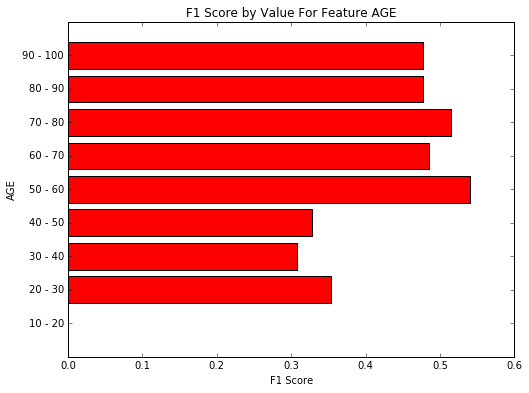

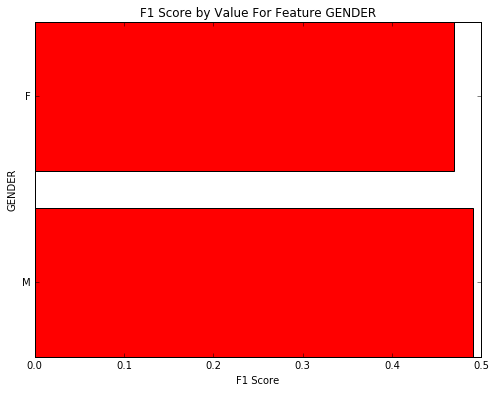

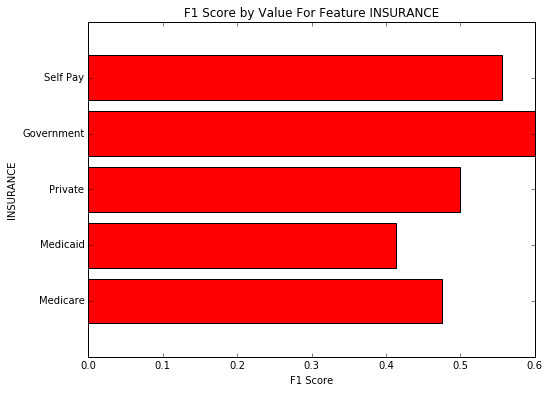

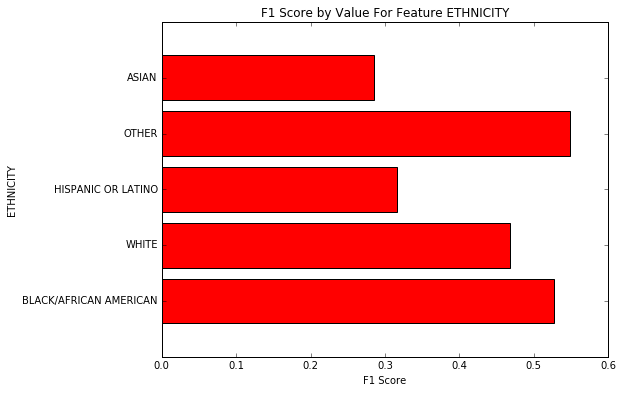

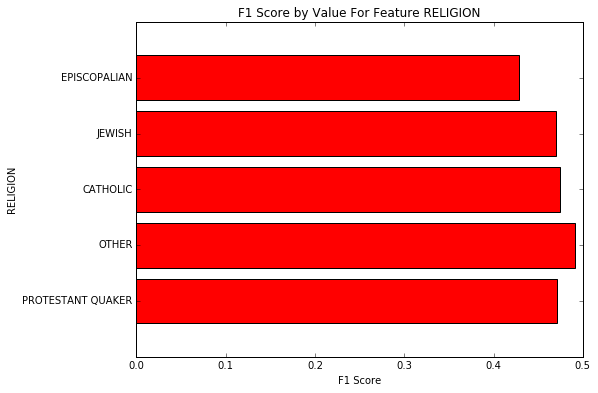

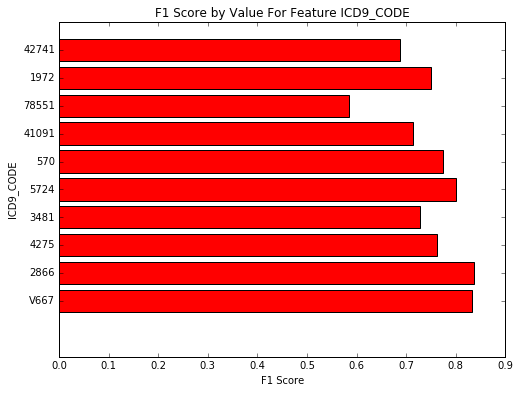

In [36]:
import matplotlib.pyplot as plt

def plotCrosscutScores(key, clf, features, labels):
    
    if key=='AGE':
        data = features.copy()
        min_value = data['AGE'].min()
        max_value = data['AGE'].max()
        value_range = max_value - min_value

        bins = np.arange(10, data['AGE'].max() + 10, 10)        
        data['AGE_BIN'] = np.digitize(data['AGE'], bins)
        
        df = pd.DataFrame(index = np.arange(0, len(bins) - 1), columns=['AGE','F1 Score'])       
        for i in range(1, len(bins)):
            subset_index = [index for index in data.index if data.loc[index, 'AGE_BIN'] == i]                     
            pred = clf.predict(data.loc[subset_index].drop(['AGE_BIN'], axis=1))
            score = f1_score(labels.loc[subset_index], pred)
            df.loc[i-1] = ['{} - {}'.format(i*10,(i+1)*10), score]     
    else:
        if key=='ICD9_CODE':
            values = ['V667', '2866', '4275', '3481', '5724', '570', '41091', '78551', '1972', '42741']  #our top 10 codes from earlier
        else:
            #Since features have been converted to dummy variables, have to go back to demographic data for a values list            
            values = er_demographic_data[key].unique()
        df = pd.DataFrame(index = np.arange(0, len(values)), columns=[key,'F1 Score'])        
        for (i, value) in enumerate(values):
            subset_index = [index for index in features.index if features.loc[index, key + '_' + value] == 1]
            pred = clf.predict(features.loc[subset_index])
            score = f1_score(labels.loc[subset_index], pred)
            df.loc[i] = [value, score]
          
    plt.figure(figsize=(8,6))
    # Set the width of each bar
    bar_width = 0.8

    for i in np.arange(len(df.index)):
        plt.barh(i - bar_width/2.0, df.loc[i, 'F1 Score'], height = bar_width, color = 'r')

    plt.yticks(np.arange(len(df[key].values)), df[key].values)    
    plt.ylabel(key)
    plt.xlabel("F1 Score")
    plt.title("F1 Score by Value For Feature {}".format(key))
    plt.show()        

er_analysis_data, labels = buildMergedData()
features_train, features_test, labels_train, labels_test = splitData(er_analysis_data, labels)
clf = AdaBoostClassifier(n_estimators=730, learning_rate=0.9, random_state=38)
clf.fit(features_train, labels_train)

plotCrosscutScores('AGE', clf, features_test, labels_test)
plotCrosscutScores('GENDER', clf, features_test, labels_test)
plotCrosscutScores('INSURANCE', clf, features_test, labels_test)
plotCrosscutScores('ETHNICITY', clf, features_test, labels_test)
plotCrosscutScores('RELIGION', clf, features_test, labels_test)
plotCrosscutScores('ICD9_CODE', clf, features_test, labels_test)

